In [1]:
# Load a cv config with all experiment parameters
# Load the corresponding data, 
# create a train and validation generator with the given parameters, exclusive the augmentation parameters
# reconstruct the model with the given parameters, (we have custom loss functions, simple model.load() will not work)
# load and apply the corresponding weights (with respect to the distributed training strategy)
# predict the targt vectors with the train and val generators (make sure that we change the batchsize to 1, and avoid shuffle so that we get all files)
# unstack each predictions and crop it by the length of the stacked gt mask
# threshold/argmax each predicted onehot-vector
# write the gt and predictions as numpy into the corresponding experiment folder (gt with gaussian, or without?, Do we save the onehot or the indicies?)

In [10]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
# local imports
from src.utils.Notebook_imports import *
from src.utils.Utils_io import Console_and_file_logger, init_config

# import external libs
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import cv2
import pandas as pd
import numpy as np
from ipyfilechooser import FileChooser


search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']


# Load a config into the global namespace

In [11]:
exp_config_chooser = FileChooser(os.path.join(os.getcwd(),'exp/cv_baseline'), '')
display(exp_config_chooser)
@interact_manual
def load_config():

    global exp_config_chooser, config
    """
    load an experiment config
    """
    if 'exp_config_chooser' in globals():
        config_file  = exp_config_chooser.selected
    else:
        print('no config chooser found')

    # load the experiment config
    with open(config_file, encoding='utf-8') as data_file:
        config = json.loads(data_file.read())
    globals().update(config)
    Console_and_file_logger(EXPERIMENT, logging.INFO)
    logging.info('Loaded config for experiment: {}'.format(config['EXPERIMENT']))

FileChooser(path='/mnt/ssd/git/dynamic-cmr-models/exp/cv_baseline', filename='', title='HTML(value='', layout=…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

# Load the corresponding file names for this fold

In [98]:
# Load SAX volumes
from src.data.Dataset import get_trainings_files
x_train_sax, y_train_sax, x_val_sax, y_val_sax = get_trainings_files(data_path=DATA_PATH_SAX,
                                                                     path_to_folds_df=DF_FOLDS,
                                                                     fold=FOLD)
logging.info('SAX train CMR: {}, SAX train masks: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('SAX val CMR: {}, SAX val masks: {}'.format(len(x_val_sax), len(y_val_sax)))

2021-03-03 12:12:21,062 INFO no files found, try to load with clean.nrrd/mask.nrrd pattern
2021-03-03 12:12:21,068 INFO Found 278 images/masks in /mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/
2021-03-03 12:12:21,068 INFO Patients train: 209
2021-03-03 12:12:21,079 INFO Selected 208 of 278 files with 209 of 279 patients for training fold 1
2021-03-03 12:12:21,080 INFO SAX train CMR: 208, SAX train masks: 208
2021-03-03 12:12:21,080 INFO SAX val CMR: 70, SAX val masks: 70


# Instantiate the train and val generators

Make sure that:
- no shuffle
- no augmentation (classic and temporal)
- batchsize equal 1, but this does not work with the model weights

In [99]:
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseRegressionGenerator
config['SHUFFLE'] = False
config['AUGMENT'] = False
config['AUGMENT_PHASES'] = False
config['BATCHSIZE'] = 1
batch_generator = PhaseRegressionGenerator(x_train_sax, x_train_sax, config=config)
# create another config for the validation data, for the case of different evaluation
val_config = config.copy()
#val_config['AUGMENT'] = False
#val_config['AUGMENT_PHASES'] = False
validation_generator = PhaseRegressionGenerator(x_val_sax, x_val_sax, config=val_config)

2021-03-03 12:12:23,823 INFO Create DataGenerator
2021-03-03 12:12:23,825 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 1
 Scaler: MinMax
 Images: 208 
 Augment: False 
 Thread workers: 8
2021-03-03 12:12:23,825 INFO No augmentation
2021-03-03 12:12:23,838 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-03-03 12:12:23,839 INFO Temporal phase augmentation: 
False
Repeat volume: 
True
2021-03-03 12:12:23,839 INFO Create DataGenerator
2021-03-03 12:12:23,840 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 1
 Scaler: MinMax
 Images: 70 
 Augment: False 
 Thread workers: 8
2021-03-03 12:12:23,840 INFO No augmentation
2021-03-03 12:12:23,854 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-03-03 12:12:23,855 INFO Temporal phase augmentation: 
False
Repeat volume: 
True


# Load the model, load and set the corresponding weights

In [100]:
from src.models.Models import create_PhaseRegressionModel
model = create_PhaseRegressionModel(config)
model.load_weights(os.path.join(config['MODEL_PATH'],'model.h5'))
logging.info('loaded model weights as h5 file')

2021-03-03 12:12:30,324 INFO loaded model weights as h5 file


Shape after the temporal encoder
(None, 36, 8, 4, 4, 512)
Shape after GAP
(None, 36, 512)
Shape after Bi-LSTM layer
(None, 36, 512)
Shape after final conv layer
(None, 36, 5)


# Predict on the validation split

In [101]:
# predict on the validation generator
preds = model.predict(validation_generator)
logging.info(preds.shape)

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[1,32,36,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node PhaseRegressionModel/conv_encoder_7/down_sample_block_28/conv_block_71/conv3d_143/Conv3D (defined at mnt/ssd/git/dynamic-cmr-models/src/models/KerasLayers.py:431) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[PhaseRegressionModel/tf_op_layer_stack_11/stack_11/_29]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[1,32,36,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node PhaseRegressionModel/conv_encoder_7/down_sample_block_28/conv_block_71/conv3d_143/Conv3D (defined at mnt/ssd/git/dynamic-cmr-models/src/models/KerasLayers.py:431) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_predict_function_351016]

Errors may have originated from an input operation.
Input Source operations connected to node PhaseRegressionModel/conv_encoder_7/down_sample_block_28/conv_block_71/conv3d_143/Conv3D:
 PhaseRegressionModel/conv_encoder_7/down_sample_block_28/dropout_35/Identity (defined at mnt/ssd/git/dynamic-cmr-models/src/models/KerasLayers.py:494)

Input Source operations connected to node PhaseRegressionModel/conv_encoder_7/down_sample_block_28/conv_block_71/conv3d_143/Conv3D:
 PhaseRegressionModel/conv_encoder_7/down_sample_block_28/dropout_35/Identity (defined at mnt/ssd/git/dynamic-cmr-models/src/models/KerasLayers.py:494)

Function call stack:
predict_function -> predict_function


# Get all GT vectors

In [ ]:
# get all ground truth vectors
gts = np.stack([np.squeeze(y) for x, y in validation_generator])
logging.info(gts.shape)

# Save gt and pred into the experiment folder

In [ ]:
pred_path = os.path.join(config['EXP_PATH'], 'pred')
ensure_dir(pred_path)
pred_filename = os.path.join(pred_path, 'gtpred_fold{}.npy'.format(config['FOLD']))
np.save(pred_filename, np.stack([gts, preds], axis=0))
logging.info('save done')

# Load the gts, predictions testwise

In [93]:
temp = np.load(pred_filename)
print(temp.shape)
gts, preds = np.split(temp,indices_or_sections=2)
gts, preds = gts[0], preds[0]
print(gts.shape)
print(preds.shape)

(2, 69, 2, 36, 5)
(69, 2, 36, 5)
(69, 2, 36, 5)


In [94]:
from src.utils.Metrics import meandiff
res = meandiff(gts,preds, apply_sum=False, apply_average=False)

In [95]:
res.shape

TensorShape([69, 5])

In [96]:
phases = ['ED', 'MS', 'ES', 'PF', 'MD']
df = pd.DataFrame(res.numpy(), columns=phases)
df.shape

(69, 5)

In [97]:
df

,ED,MS,ES,PF,MD
0,1,1,2,0,1
1,2,2,0,0,2
2,1,0,1,0,1
3,1,1,1,0,1
4,0,0,1,0,0
...,...,...,...,...,...
64,0,2,2,1,0
65,2,1,1,0,2
66,1,1,1,1,2
67,1,0,0,1,1


# Error per Phase

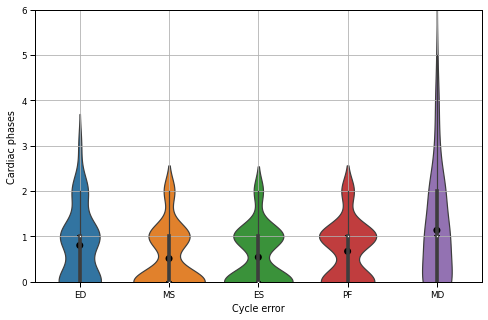

In [81]:
import seaborn as sb
sb.set_context('paper')
f = plt.figure(figsize=(8,5))
ax = f.gca()
ax.set_ylim(bottom=0, top=6)
ax.set_ylabel('Cardiac phases')
ax.set_xlabel('Cycle error')
#_ = DF_METADATA[phases].plot(kind='violin'),
sb.violinplot(data=df, orient='v', ax = ax)
sb.pointplot(data=df, orient='v', ax = ax, estimator=np.mean,color="black", markers="o", ci=None,join=False)
sb.pointplot(data=df, orient='v', ax = ax, estimator=np.median,color="black", markers="_", ci=None,join=False)
plt.grid()
plt.show()

# Error per cardiac cycle

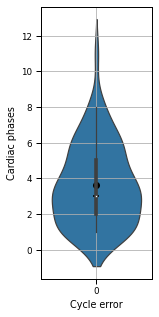

In [80]:
import seaborn as sb
sb.set_context('paper')
f = plt.figure(figsize=(2,5))
ax = f.gca()
ax.set_ylabel('Cardiac phases')
ax.set_xlabel('Cycle error')
temp = df.sum(axis=1)
sb.violinplot(data=temp, orient='v', ax = ax)
#sb.scatterplot(data=temp, ax=ax)
sb.pointplot(data=temp, orient='v', ax = ax, estimator=np.mean,color="black", markers="o", ci=None,join=False)
sb.pointplot(data=temp, orient='v', ax = ax, estimator=np.median,color="black", markers="_", ci=None,join=False)
plt.grid()
plt.show()